# 0. Khởi động

In [1]:
# !wget "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip"
# !unzip GTSRB_Final_Training_Images.zip

GTSRB_DATA_DIR = "/content/GTSRB/Final_Training/Images"

In [2]:
import tensorflow as tf
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import glob
from tensorflow.keras.preprocessing import image

import PIL

import csv

In [ ]:
url_data = "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip"
tf.keras.utils.get_file(
    fname = 'GTSRB_Final_Training_Images.zip', 
    origin = url_data, 
    cache_subdir='datasets', 
    extract=True
)

276299776/276294756 [==============================] - 3s 0us/step


'/root/.keras/datasets/GTSRB_Final_Training_Images.zip'

In [ ]:
DOWNLOAD_DIR = "/root/.keras/datasets/"
GTSRB_DATA_DIR = os.path.join(DOWNLOAD_DIR,  "GTSRB/Final_Training/Images")

In [ ]:
N_CLASSES = 43
RESIZED_HIGHT = RESIZED_WIDTH = 28
RESIZED_IMAGE = (RESIZED_HIGHT, RESIZED_WIDTH)
SPLIT_SIZE = 0.8

## 1.1 Some functions: Split data, Read labels and boxes, Read img to arr

In [ ]:
def split_data_idx(m, split_size):
    training_length = int(split_size * m)
    #random.seed(42)
    shuffled_idx = random.sample(range(m), m)  
    trainning_idx = shuffled_idx[0:training_length]
    testing_idx = shuffled_idx[training_length:]
    return trainning_idx, testing_idx

In [ ]:
def load_image_to_array(file_path):
  img = image.load_img(file_path, target_size = RESIZED_IMAGE)
  arr = image.img_to_array(img)
  return arr 

# def read_images_from_directory(file_path):
#   file_paths = glob.glob(SOURCE + "/*.ppm")
#   file_paths = sorted(file_paths)  #sorted is OK
#   arr_of_imgs =  list(map(load_image_to_array, file_paths))
#   #arr_of_imgs = [load_image_to_array(file_path) for file_path in file_paths]
#   return arr_of_imgs

In [ ]:
def read_sizes_labels_boxes(file_path):
    sizes =  [] 
    labels = [] 
    boxes =  [] 
    with open(file_path) as f:
        reader = csv.reader(f, delimiter=';')
        next(reader) # skip header
        for row in reader:
          sizes.append(list(map(float, row[1:3])))
          boxes.append(list(map(float, row[3:7]))) 
          labels.append(int(row[7])) # label is in the 7th column    
    return sizes, labels, boxes

## 1.2 Test Functions

In [ ]:
# """ TEST THE FUNCTION split_data_idx """
# a, b = split_data_idx(10, 0.7)
# print(a)
# print(b)

In [ ]:
#""" TEST THE FUNCTION read_images_from_directory """
# SOURCE = '/content/GTSRB/Final_Training/Images/00000'
# images = read_images_from_directory(SOURCE)
# len(images)

In [ ]:
# """ TEST THE FUNCTION read_sizes_labels_boxes """
# file_path = '/content/GTSRB/Final_Training/Images/00000/GT-00000.csv'
# sizes, labels, boxes = read_sizes_labels_boxes(file_path)
# print(len(sizes), len(labels), len(boxes))
# print(sizes[1], labels[2], boxes[3])
# print(sizes[3:5])

## 1.3 Extract data to train, test

In [ ]:
X_train = []
X_test = []
y_train = []
y_test = []
boxes_train = []
boxes_test = []
sizes_train = []
sizes_test = []



In [ ]:
for i in range(N_CLASSES):
  root_name = format(i, '05d') 
  SOURCE = os.path.join(GTSRB_DATA_DIR, root_name)
  
  img_file_paths = glob.glob(SOURCE + "/*.ppm")
  m = len(img_file_paths)
  #CSV FILE
  csv_file_path = os.path.join(SOURCE, 'GT-' + root_name +'.csv')
  sizes, labels, boxes = read_sizes_labels_boxes(csv_file_path)

  # IMAGE FILES
  img_file_paths = sorted(img_file_paths)
  arr_of_imgs = list(map(load_image_to_array, img_file_paths))
  
  #SPLITING
  trainning_idx, testing_idx = split_data_idx(m, SPLIT_SIZE) 
  
  X_train.extend([arr_of_imgs[id] for id in trainning_idx])
  X_test.extend([arr_of_imgs[id] for id in testing_idx])

  y_train.extend([labels[id] for id in trainning_idx])
  y_test.extend([labels[id] for id in testing_idx])

  boxes_train.extend([boxes[id] for id in trainning_idx])
  boxes_test.extend([boxes[id] for id in testing_idx])

  sizes_train.extend([sizes[id] for id in trainning_idx])
  sizes_test.extend([sizes[id] for id in testing_idx])

In [ ]:
len(X_train), len(y_train), len(X_test), len(y_test), len(boxes_test), len(boxes_train)

(31367, 31367, 7842, 7842, 7842, 31367)

## 1.4 Overview images

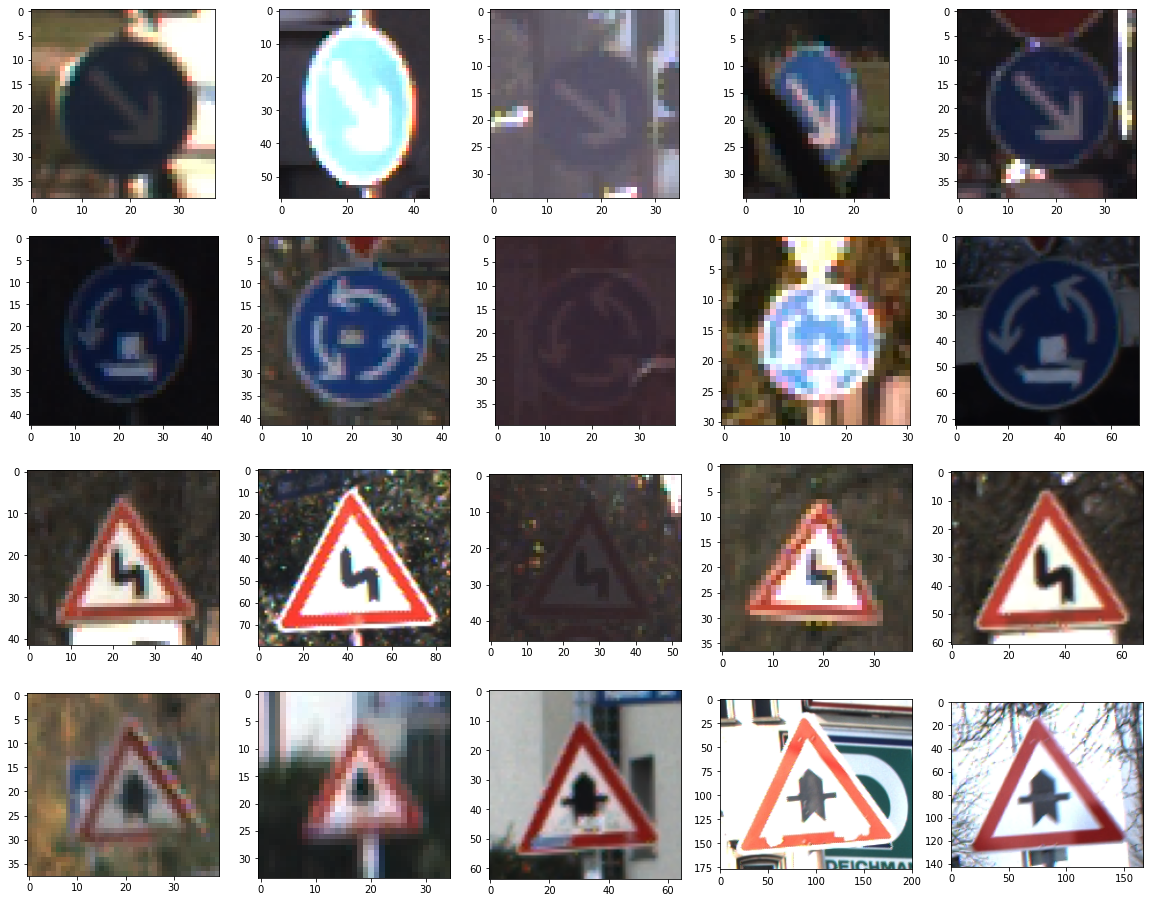

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.image as mpimg
nrows = 4
ncols = 5
fig, ax = plt.subplots(nrows, ncols)
#fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)


for i in range(nrows):  # chọn 4 folder bất kì
  no_class = np.random.choice(range(N_CLASSES))
  directory = os.path.join(GTSRB_DATA_DIR, format(no_class, '05d'))
  all_file_names_in_one_folder = sorted(glob.glob(directory + "/*.ppm"))
  for j in range(ncols):
    img_path = np.random.choice(all_file_names_in_one_folder)
    img = mpimg.imread(img_path)
    ax[i,j].imshow(img)
plt.show()

## 1.5 Tao data TFDS

In [ ]:
for i in range(len(boxes_train)):
  boxes_train[i][0] = int(boxes_train[i][0] * RESIZED_WIDTH/sizes_train[i][0])
  boxes_train[i][2] = int(boxes_train[i][2] * RESIZED_WIDTH/sizes_train[i][0])
  
  boxes_train[i][1] = int(boxes_train[i][1] * RESIZED_HIGHT/sizes_train[i][1])
  boxes_train[i][3] = int(boxes_train[i][3] * RESIZED_HIGHT/sizes_train[i][1])


In [ ]:
#Creat my data
ds_train = tf.data.Dataset.from_tensor_slices((X_train, (y_train, boxes_train)))

ds_train = ds_train.shuffle(1000)
ds_train = ds_train.repeat() # Mandatory for Keras for now
ds_train = ds_train.batch(64, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed
ds_train = ds_train.prefetch(1)

In [ ]:
for i in range(len(boxes_test)):
  boxes_test[i][0] = int(boxes_test[i][0] * RESIZED_WIDTH/sizes_test[i][0])
  boxes_test[i][2] = int(boxes_test[i][2] * RESIZED_WIDTH/sizes_test[i][0])
  
  boxes_test[i][1] = int(boxes_test[i][1] * RESIZED_HIGHT/sizes_test[i][1])
  boxes_test[i][3] = int(boxes_test[i][3] * RESIZED_HIGHT/sizes_test[i][1])



#Creat my data
ds_test = tf.data.Dataset.from_tensor_slices((X_test, (y_test, boxes_test)))

ds_test = ds_test.shuffle(100)
ds_test = ds_test.repeat() # Mandatory for Keras for now
ds_test = ds_test.batch(64, drop_remainder=True) # drop_remainder is important on TPU, batch size must be fixed


# 2. Models

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras import Input 
from tensorflow.keras.models import Model
from tensorflow.python.keras.utils.vis_utils import plot_model

In [ ]:
def feature_extractor(inputs):
    x = tf.keras.layers.Conv2D(16, (3,3), activation='relu')(inputs) # input_shape=(RESIZED_HIGHT, RESIZED_WIDTH, 3)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(64,kernel_size=3,activation='relu')(x)
    x = tf.keras.layers.AveragePooling2D((2, 2))(x)

    return x

def dense_layers(inputs):
  x = tf.keras.layers.Flatten()(inputs)
  x = tf.keras.layers.Dense(128, activation='relu')(x)
  return x

In [ ]:
def classifier(inputs):

  classification_output = tf.keras.layers.Dense(43, activation='softmax', name = 'classification')(inputs)
  return classification_output


def bounding_box_regression(inputs):
    bounding_box_regression_output = tf.keras.layers.Dense(units = '4', name = 'bounding_box')(inputs)
    return bounding_box_regression_output

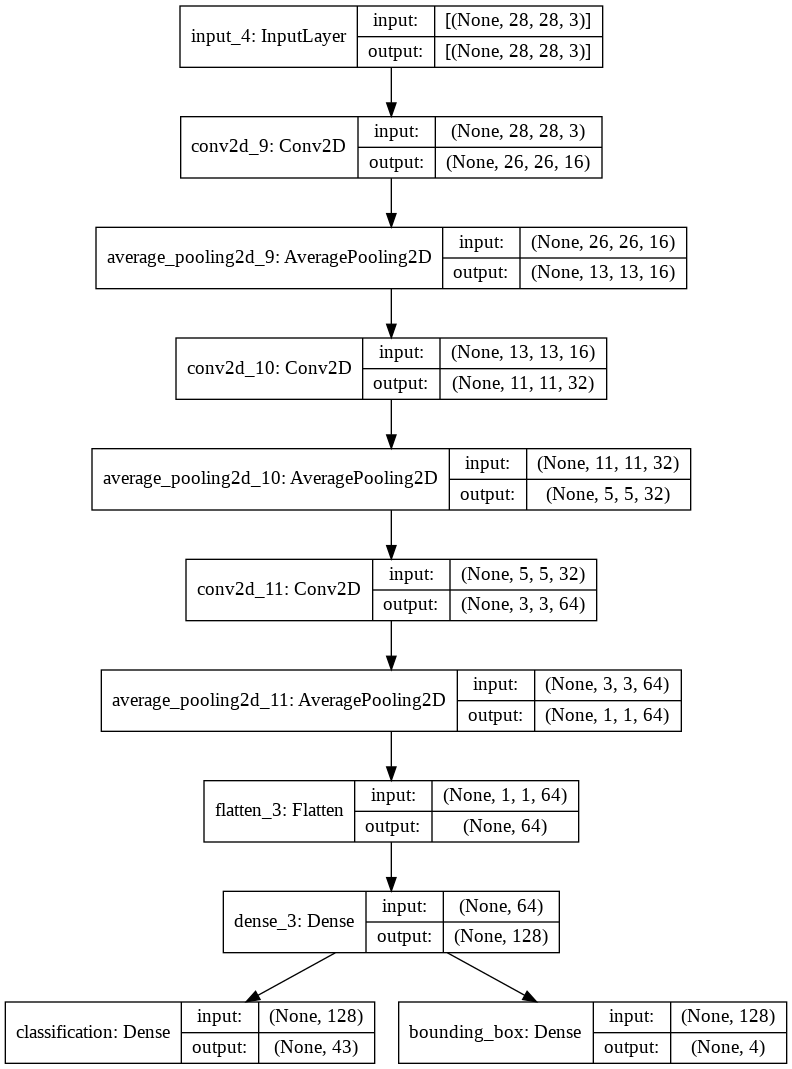

In [ ]:
def final_model(inputs):
    feature_cnn = feature_extractor(inputs)
    dense_output = dense_layers(feature_cnn)

    classification_output = classifier(dense_output)
    bounding_box_output = bounding_box_regression(dense_output)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_output, bounding_box_output])

    return model
  

inputs = tf.keras.layers.Input(shape=(RESIZED_HIGHT, RESIZED_WIDTH, 3))
model = final_model(inputs)



  



    



# print model layers
#model.summary()
plot_model(model, show_shapes=True, show_layer_names=True, to_file='base-model.png')




# def get_model():

#   input_layer = Input(input_shape=(28, 28, 3))
#   #sharp = Sharpen(num_outputs=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS, ))(input_layer)
#   #Convolution, maxpool and dropout layers
#   x = Conv2D(32, (5,5), activation = 'relu', input_shape=(28, 28, 3))(input_layer)
#   x = Conv2D(64, (3,3), activation = 'relu')(x)
#   x = MaxPooling2D(2,2)(x)
#   x = Conv2D(64, (3,3), activation = 'relu')(x)
#   x = MaxPooling2D(2,2)(x)
#   x = Flatten()(x)
#   x = Dense(256, activation = 'relu')(x)
#   cls_ouput = Dense(units = 43, activation='softmax', name="classification")(x)
#   reg_output = Dense(units = 4, activation = 'linear', name = "regression")(x)
 
#   model = Model(inputs = input_layer, outputs = [cls_ouput, reg_output])
#   return model

In [ ]:
def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  tf.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = tf.split(true_box, 4, axis = 1)


    xmin_overlap = tf.math.maximum(xmin_pred, xmin_true)
    xmax_overlap = tf.math.minimum(xmax_pred, xmax_true)
    ymin_overlap = tf.math.maximum(xmin_pred, xmin_true)
    ymax_overlap = tf.math.minimum(ymax_pred, ymax_true)

    pred_box_area = (xmax_pred - xmin_pred ) * (ymax_pred - ymin_pred )
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    overlap_area = tf.math.maximum((xmax_overlap - xmin_overlap), 0)  * tf.math.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    iou = overlap_area / union_area

    return iou

In [ ]:
model.compile(optimizer='adam', 
              loss = {'classification' : 'sparse_categorical_crossentropy',
                      'bounding_box' : 'mse'
                     },
              metrics = {'classification' : 'accuracy',
                         'bounding_box' : intersection_over_union
                        })

# 50. FIT TRAIN

In [ ]:
EPOCHS = 20 # 45
steps_per_epoch = len(y_train)//64  # 60,000 items in this dataset
validation_steps = 1

history = model.fit(ds_train, epochs=EPOCHS,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=ds_test, 
                    validation_steps=validation_steps
                    )

Epoch 1/20
490/490 [==============================] - 2s 3ms/step - loss: 0.6503 - classification_loss: 0.0378 - bounding_box_loss: 0.6125 - classification_accuracy: 0.9877 - bounding_box_intersection_over_union: 0.8367 - val_loss: 12.0503 - val_classification_loss: 1.3021 - val_bounding_box_loss: 10.7482 - val_classification_accuracy: 0.8594 - val_bounding_box_intersection_over_union: 0.3762
Epoch 2/20
490/490 [==============================] - 2s 3ms/step - loss: 0.6818 - classification_loss: 0.0373 - bounding_box_loss: 0.6445 - classification_accuracy: 0.9872 - bounding_box_intersection_over_union: 0.8326 - val_loss: 15.8281 - val_classification_loss: 1.1942 - val_bounding_box_loss: 14.6339 - val_classification_accuracy: 0.8438 - val_bounding_box_intersection_over_union: 0.3381
Epoch 3/20
490/490 [==============================] - 2s 3ms/step - loss: 0.6837 - classification_loss: 0.0399 - bounding_box_loss: 0.6438 - classification_accuracy: 0.9876 - bounding_box_intersection_over_un